In [ ]:
%cd Documents/GitHub/StatApp_2020

[Errno 2] No such file or directory: 'Documents/GitHub/StatApp_2020'
/Users/h2jw/Documents/GitHub/StatApp_2020


In [ ]:
%cd Modélisation
%ls

[Errno 2] No such file or directory: 'Modélisation'
/Users/h2jw/Documents/GitHub/StatApp_2020/Modélisation
Comparaisons previsions.ipynb   Visu_Previsions_NP.pbix
Modele_ARIMA.py                 Visu_Previsions_NP_Arrivee.pdf
Modele_NP.py                    __main__.py
Modele_NP_KWT*                  __pycache__/
Modele_NP_final.py              test/
NP_Boudra.py


In [ ]:
import math
from datetime import timedelta

import pandas as pd
import numpy as np
import Modele_NP_KWT as kwt
import Modele_NP_final as model_np
from tqdm import tqdm 

In [ ]:

dateDebMod = pd.to_datetime("2007-01-01")
dateFinMod = pd.to_datetime("2015-12-31")


horizonsPrev = [7, 31+29+31, 365] #Prédictions sur une semaine, 3 mois et un an
            

database = pd.read_csv("/Users/h2jw/Documents/GitHub/StatApp_2020/Data/database_sieges.csv",low_memory=False,decimal=',')
database['Coeff_Rempl']=database['PAX'].astype('float')/database["Sièges Corrections_ICI"].astype('float')
database = database.astype({'Date': 'datetime64[ns]','PAX_FQM':'float','Sièges Corrections_ICI':'float','Coeff_Rempl':'float','Coeff_Rempl_FQM':'float'})
database = database.groupby(['Date','Faisceau','ArrDep']).agg({'PAX':'sum','PAX_FQM':'sum','Sièges Corrections_ICI':'sum','Coeff_Rempl':'mean','Coeff_Rempl_FQM':'mean'}).reset_index()

Calendrier = pd.read_csv("/Users/h2jw/Documents/GitHub/StatApp_2020/Data/Calendrier/Calendrier.csv", dayfirst = True , sep = ';' , parse_dates = ['Date'])

histoMod = database[(database['Date']>=dateDebMod) & (database['Date']<=dateFinMod)]
# histoMod.to_csv("HistoMod.csv")

histoPrev = database[(database['Date']>dateFinMod) & (database['Date']<=dateFinMod+timedelta(days = hPrev))]   

hPrev = 7
Prev_NP = pd.DataFrame()
Prev_KWT = pd.DataFrame()

for faisceau in ['National', 'Schengen', 'Autre UE', 'International', 'Dom Tom'] :
    for mvt in ['Arrivée', 'Départ'] :

        histoMod_2 = histoMod[(histoMod['Faisceau']==faisceau) & (histoMod['ArrDep']==mvt)]


        # Modèle Non-Paramétrique :
        prev_NP = model_np.previsions_NP(histoMod_2, Calendrier, dateDebMod, dateFinMod, hPrev)
        prev_KWT = kwt.previsions_NP_KWT(histoMod_2, dateFinMod, hPrev)
        Prev_NP = pd.concat([Prev_NP, prev_NP],ignore_index=True)  
        Prev_KWT = pd.concat([Prev_KWT, prev_KWT])


# Ajout des prévisions du modèle NP et NP avec ondelettes à histoPrev           
histoPrev = pd.concat([histoPrev.set_index(['Date','Faisceau','ArrDep']),Prev_NP.set_index(['Date','Faisceau','ArrDep']),Prev_KWT.set_index(['Date','Faisceau','ArrDep'])],axis=1)
histoPrev = histoPrev.reset_index()





In [ ]:
histoPrev.to_csv('prev_7_jours.csv')

In [ ]:
histoPrev.head()

,Date,Faisceau,ArrDep,PAX,PAX_FQM,Sièges Corrections_ICI,Coeff_Rempl,Coeff_Rempl_FQM,PAX_NP,IC95.0_low_NP,IC95.0_up_NP,PAX_NP
0,2016-01-01,Autre UE,Arrivée,621,567.00,877.311749,0.667869,0.685714,484.689369,426.155061,584.663376,708.255442
1,2016-01-01,Autre UE,Départ,561,564.30,737.750683,0.757917,0.833333,936.163248,520.510773,1100.283716,713.697185
2,2016-01-01,Dom Tom,Arrivée,4946,5175.43,5550.247131,0.881251,0.912857,5135.608859,4187.852415,5648.799399,5046.753321
3,2016-01-01,Dom Tom,Départ,4282,4333.00,6103.909119,0.703995,0.675000,5243.083772,4281.222365,5880.438877,5320.410494
4,2016-01-01,International,Arrivée,7557,8100.04,9713.552023,0.777457,0.853077,10163.016864,8564.040412,10957.498650,8378.636710


<AxesSubplot:>

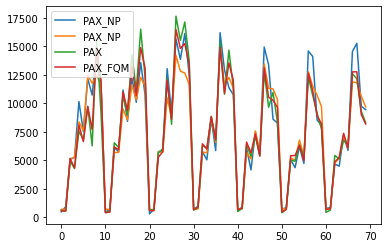

In [ ]:
histoPrev[['PAX_NP','PAX', 'PAX_FQM']].plot()

In [1]:
%matplotlib inline

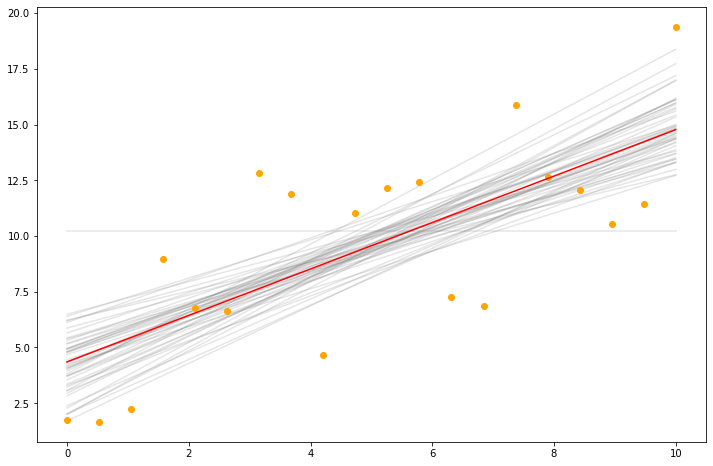

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.ensemble import BaggingRegressor

# Create toy data 
x = np.linspace(0, 10, 20)
y = x + (np.random.rand(len(x)) * 10)

# Extend x data to contain another row vector of 1s
X = np.vstack([x, np.ones(len(x))]).T

n_estimators = 50

model = BaggingRegressor(LassoCV(cv=5, random_state=0), 
                         n_estimators=n_estimators,
                         bootstrap=True)

model.fit(X, y)

plt.figure(figsize=(12,8))

# Accessing each base_estimator (already fitted)
for m in model.estimators_:
    plt.plot(x, m.predict(X), color='grey', alpha=0.2, zorder=1)

plt.scatter(x,y, marker='o', color='orange', zorder=4)

# "Bagging model" prediction
plt.plot(x, model.predict(X), color='red', zorder=5)

In [ ]:
from mlinsights.mlmodel import IntervalRegressor


lin = IntervalRegressor(LassoCV())
lin.fit(X_train, y_train)



In [11]:
!pip install mlinsights

     |████████████████████████████████| 2.0MB 4.0MB/s 
     |████████████████████████████████| 133kB 20.1MB/s 


# Brouillon pour IC lasso

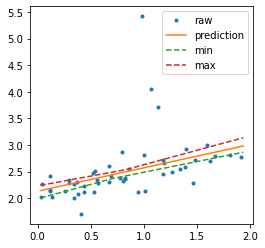

In [49]:
from numpy.random import randn, binomial, rand
N = 200
X = rand(N, 1) * 2
eps = randn(N, 1) * 0.2
eps2 = randn(N, 1) + 1
bin = binomial(2, 0.05, size=(N, 1))
y = (0.5 * X + eps + 2 + eps2 * bin).ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from mlinsights.mlmodel import IntervalRegressor

lin = IntervalRegressor(alpha = 0.95, estimator=LinearRegression())
lin.fit(X_train, y_train)

sorted_X = numpy.array(list(sorted(X)))
pred = lin.predict(sorted_X)
bootstrapped_pred = lin.predict_sorted(sorted_X)
min_pred = bootstrapped_pred[:, 0]
max_pred = bootstrapped_pred[:, bootstrapped_pred.shape[1]-1]


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X_test, y_test, '.', label="raw")
ax.plot(sorted_X, pred, label="prediction")
ax.plot(sorted_X, min_pred, '--', label="min")
ax.plot(sorted_X, max_pred, '--', label="max")
ax.legend();

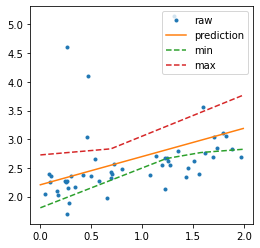

In [52]:
from numpy.random import randn, binomial, rand
N = 200
X = rand(N, 1) * 2
eps = randn(N, 1) * 0.2
eps2 = randn(N, 1) + 1
bin = binomial(2, 0.05, size=(N, 1))
y = (0.5 * X + eps + 2 + eps2 * bin).ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from mlinsights.mlmodel import IntervalRegressor


reg= BaggingRegressor(LassoCV(cv=5, random_state=0), 
                         n_estimators=n_estimators,
                         bootstrap=True)

model = IntervalRegressor(alpha=0.05, estimator=reg)
model.fit(X_train, y_train)

sorted_X = numpy.array(list(sorted(X)))
pred = model.predict(sorted_X)
bootstrapped_pred = model.predict_sorted(sorted_X)
min_pred = bootstrapped_pred[:, 0]
max_pred = bootstrapped_pred[:, bootstrapped_pred.shape[1]-1]


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(X_test, y_test, '.', label="raw")
ax.plot(sorted_X, pred, label="prediction")
ax.plot(sorted_X, min_pred, '--', label="min")
ax.plot(sorted_X, max_pred, '--', label="max")
ax.legend();

In [55]:
len(min_pred), len(pred)

(200, 200)

# Nouvelles visualisations avec IC Lasso

sample_data
